Импортируем все необходимые библиотеки

In [1]:
import pandas as pd
import sklearn
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dikki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dikki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Читаем данные с помощью pandas. Можно указать разделитель - запятую

In [2]:
df = pd.read_csv("labeled.csv", sep=',')

Смотрим размер данных. 14412 строк и 2 колонки

In [3]:
df.shape

(14412, 2)

Смотрим первые 5 записей

In [4]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


Приводим значения в столбце ```toxic``` к ```int```. Используем функцию ```apply```, которая применит к каждой строчке одну и ту же функцию

In [5]:
df["toxic"] = df["toxic"].apply(int)

Смотрим снова данные

In [6]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


Смотрим распределение данных по токсичности

In [7]:
df["toxic"].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

Смотрим примеры токсичных комментариев. 

In [8]:
for c in df[df["toxic"] == 1]['comment'].head(5):
    print(c)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



Потом не токсик со значением 0

In [9]:
for c in df[df["toxic"] == 0]['comment'].head(5):
    print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

Берём 500 сэмплов на тест

In [10]:
train_df, test_df = train_test_split(df, test_size=500)

Проверяем что действительно 500

In [11]:
test_df.shape

(500, 2)

Смотрим распределение токсичности

In [12]:
test_df["toxic"].value_counts()

0    328
1    172
Name: toxic, dtype: int64

In [13]:
train_df["toxic"].value_counts()

0    9258
1    4654
Name: toxic, dtype: int64

Будем использовать логистическую регрессию. Пред этим необходимо из теста сделать численные векторы, потому что сама модель на вход принимает вещественные векторы.
1. Нужно будет разбить текст на токены
2. Удалить токены без смысловой инфорамции
3. К каждому токену применть стемминг. Удалить у слова окончание и привести всё к нижнему регистру


Берём один пример (один комментарий)

In [14]:
sentence_example = df.iloc[1]["comment"]

Вызываем функцию ```word_tokenize``` из библиотеки ```nltk```, которая разбивает текст на токены. Разбивает по пробелам и знакам пунктуации.

In [15]:
tokens = word_tokenize(sentence_example, language="russian")

Удаляем знаки пунктуации. Для этого импортируем стандартный модуль ```string```  в котором есть массив ```punctuation```, который содержит все знаки пунктуации.

In [16]:
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]

Из библиотеки ```nltk``` получаем русские стоп слова и удаляем их

In [17]:
russian_stop_words = stopwords.words("russian")

In [18]:
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]

Приводим к нижнему ригистру и удаляем окончания

In [19]:
snowball = SnowballStemmer(language="russian")

In [20]:
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

Напечатаем примеры

In [21]:
print(f"Исходный текст: {sentence_example}")
print("-----------------")
print(f"Токены: {tokens}")
print("-----------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("-----------------")
print(f"Токены без пунктуаци и стоп слов: {tokens_without_stop_words_and_punctuation}")
print("-----------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("-----------------")

Исходный текст: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

-----------------
Токены: ['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
-----------------
Токены без пунктуации: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
-----------------
Токены без пунктуаци и стоп слов: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
-----------------
Токены после стемминга: ['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисел', 'придума']
-----------------


Напишем функцию чтобы могли этап предобработки применять для каждого предложения в нашем df. Создаём стеммер и список стоп слов.

In [22]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentetnce(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

Проверим на примере как работает функция

In [23]:
tokenize_sentetnce(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

После того как готов массив токенов мы можем применять векторизацию. Создаём векторайзер. В нём переопределяем токенайзер на наш токенайзер.

In [24]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentetnce(x, remove_stop_words=True))

Вызываем функцию ```fit_transform``` и передаём ему список наших предложений. Функция вернёт готовые фичи, которые можно будет передавать в модель машинного обучения

In [25]:
features = vectorizer.fit_transform(train_df["comment"])

Фичи готовы, теперь можем обучать модель логистической регрессии. Сначала создаём класс логистической регрессии ```LogisticRegression```, передаём в неё ```random_state=0``` это делается для того, чтобы результаты были воспроизводимы. Потом вызываем метод ```fit```, который используется для обучения, куда передаём наши фичи(```features```) и лэйблы ```train_df["toxic"]``` тоесть разметку коменнтариев

In [26]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df["toxic"])

LogisticRegression(random_state=0)

Проверим как работает модель.

In [27]:
model.predict(features[0])

array([0], dtype=int64)

 Для первого коммента вернула то, что он нормальный попробуем его просто прочитать. Каждый раз разное!

In [28]:
train_df["comment"].iloc[0]

'Интересная информация, особенно на фоне того, что Ростелеком поднял цены на интернет минимум на 150 руб. месяц назад.\n'

Существует такой класс как ```Pipeline```, который позволяет соеденить создание фичей и уже модель

In [29]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentetnce(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0))
])

Мы передаём список предложений и лейблов для этих предложений

In [30]:
model_pipeline.fit(train_df["comment"], train_df["toxic"])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000019C2890A0D0>)),
                ('model', LogisticRegression(random_state=0))])

Попробуем придумать позитивный и негативный текст и посмотрим что он вернёт

In [31]:
model_pipeline.predict(["Привет, у меня всё нормально"])

array([0], dtype=int64)

In [32]:
model_pipeline.predict(["Слушай не пойти ли тебе нафиг отсюда?"])

array([1], dtype=int64)

Исходя из этих двух примеров можно сказать, что модель работает нормально, но нам нужно измерить метрики

In [34]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.8974358974358975

In [35]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.6104651162790697

Нам нужен precision минимум 95, значит такая модель нам не подходит. Есть функция чтобы рисовать precision-recall кривую, порог меняется от 0 до 1 и в зависимости от него считается precision и recall и после этого рисуется граик зависимости.

In [38]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])

Есть стандартная функция чтобы нарисовать эту кривую

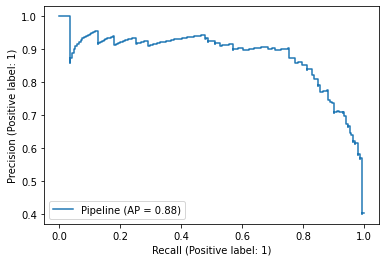

In [39]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])

Необходимо найти момент где precision > 0.95

In [40]:
np.where(prec > 0.95)

(array([404, 405, 406, 421, 422, 423, 424, 425, 426, 427], dtype=int64),)

Начиная с 404 значения порога значение precision удовлетворяет нашим условиям. Напечатаем минимальный порог, который нас устраивает.

In [41]:
thresholds[404]

0.8475278107995122

Попробуем вызвать предсказание с этим порогом

In [42]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[404])

0.9545454545454546

Посчитаем recall при этом пороге

In [43]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[404])

0.12209302325581395

1. Попробуем подобрать гиперпараметры, которые её улучшат.
2. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
3. Попробуем различные коэффициенты регуляризации и посмотрим как это будет влиять на наши метрики
4. Напишем новый пайплайн в котором будем использовать обёрнутый в GridSearchCV векторайзер и логистическую регрессию.

Передаём векторайзер как он у нас был раньше, а модель поменялась логистическая регрессия обёрнута в ```GridSearchCV```. Мы перебираем 3 коэффиицента регуляризации - стандарт это 1, берём в 10 раз меньше и в 10 раз больше. ```cv=3``` значит, что мы будем разбивать на 3 фолда во время кросвельдации и ```verbose=4``` значит что мы будем выводить всю информацию об обучении сюда 

In [44]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentetnce(x, remove_stop_words=True))),
    ("model",
    GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )
    )
])

In [46]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.687 total time=   1.1s
[CV 2/3] END .............................C=0.1;, score=0.687 total time=   0.2s
[CV 3/3] END .............................C=0.1;, score=0.686 total time=   0.2s
[CV 1/3] END ...............................C=1;, score=0.837 total time=   0.5s
[CV 2/3] END ...............................C=1;, score=0.835 total time=   0.4s
[CV 3/3] END ...............................C=1;, score=0.836 total time=   0.4s


C:\Users\dikki\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ............................C=10.0;, score=0.861 total time=   0.9s


C:\Users\dikki\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ............................C=10.0;, score=0.868 total time=   0.9s


C:\Users\dikki\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ............................C=10.0;, score=0.870 total time=   1.1s


C:\Users\dikki\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000019C290DF8B0>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

Лучший показатель при коэффициенте регуляризации = 10. Но при этом модель не сошлась и ей не удалось обучиться ConvergenceWarning: lbfgs failed to converge (status=1). 

Проверим и обучим новую модель используя коэффициент 10

In [48]:
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentetnce(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
])

In [49]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

C:\Users\dikki\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000019C2890A280>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [50]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])

In [51]:
np.where(prec_c_10 > 0.95)

(array([310, 311, 312, 313, 314, 319, 320, 321, 322, 323, 324, 325, 326,
        327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
        353, 354, 375], dtype=int64),)

In [53]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[310])

0.953125

In [54]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[310])

0.3546511627906977

Мы смогли выявить в 3 раза больше негативных комментариев при этом сохранив хороший precision изменив коэффициент регуляризации